In [6]:
import glob
import matplotlib.pyplot as plt
from random import choice

reference_folder = "/home/adelb/Documents/Bpartners/Stanislas/datasetv1/val/images"
target_folder = 'test_images'


In [109]:
import os
import cv2
import numpy as np
from skimage import exposure

# ---------- Helpers ----------

def compute_cdf(img_gray):
    """Compute normalized CDF for grayscale image."""
    hist, bins = np.histogram(img_gray.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf = cdf / cdf[-1]  # normalize
    return cdf

def match_cdf(src_gray, target_cdf):
    """Histogram specification: match src_gray to target_cdf."""
    src_hist, bins = np.histogram(src_gray.flatten(), 256, [0,256])
    src_cdf = src_hist.cumsum()
    src_cdf = src_cdf / src_cdf[-1]

    # build LUT by matching closest CDF values
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        diff = np.abs(src_cdf[i] - target_cdf)
        lut[i] = np.argmin(diff)

    return cv2.LUT(src_gray, lut)

def apply_texture(img, texture=0.3):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float32)
    
    # Texture enhancement (local contrast)
    L = lab[:,:,0].astype(np.uint8)
    blurred = cv2.GaussianBlur(L, (0,0), 3)
    L_tex = cv2.addWeighted(L, 1 + texture, blurred, -texture, 0)
    lab[:,:,0] = np.clip(L_tex, 0, 255)
    
    out = cv2.cvtColor(lab.astype(np.uint8), cv2.COLOR_LAB2BGR)
    return out

# ---------- Step 1: Build profile ----------

def build_profile(preprocessed_folder, out_file="profile.npz"):
    means, stds, cdfs, sharps = [], [], [], []

    for fname in os.listdir(preprocessed_folder):
        path = os.path.join(preprocessed_folder, fname)
        img = cv2.imread(path)
        if img is None:
            continue

        # LAB stats
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float32)
        means.append(lab.mean(axis=(0,1)))
        stds.append(lab.std(axis=(0,1)))

        # luminance CDF (from L channel)
        L = lab[:,:,0].astype(np.uint8)
        cdfs.append(compute_cdf(L))

        # sharpness

    profile = {
        "lab_means": np.mean(means, axis=0),
        "lab_stds": np.mean(stds, axis=0),
        "cdf_mean": np.mean(cdfs, axis=0),
    }
    np.savez(out_file, **profile)
    print(f"Profile saved to {out_file}")

# ---------- Step 2: Apply profile ----------

def apply_profile(img, profile_file="profile.npz", texture=.1):
    prof = np.load(profile_file)

    lab_means = prof["lab_means"]
    lab_stds = prof["lab_stds"]
    cdf_mean = prof["cdf_mean"]
    print(cdf_mean.shape)


    # --- Color transfer (LAB mean/std) ---
    src_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float32)
    src_mean = src_lab.mean(axis=(0,1))
    src_std = src_lab.std(axis=(0,1))

    l_new = (src_lab[:,:,0] - src_mean[0]) * (lab_stds[0]/src_std[0]) + lab_means[0]
    a_new = (src_lab[:,:,1] - src_mean[1]) * (lab_stds[1]/src_std[1]) + lab_means[1]
    b_new = (src_lab[:,:,2] - src_mean[2]) * (lab_stds[2]/src_std[2]) + lab_means[2]

    l_new = np.clip(l_new, 0, 255).astype(np.uint8)
    a_new = np.clip(a_new, 0, 255).astype(np.uint8)
    b_new = np.clip(b_new, 0, 255).astype(np.uint8)

    lab_new = cv2.merge([l_new, a_new, b_new])
    img_colored = cv2.cvtColor(lab_new, cv2.COLOR_LAB2BGR)

    # --- Exposure match (histogram specification of L channel) ---
    lab2 = cv2.cvtColor(img_colored, cv2.COLOR_BGR2LAB)
    L = lab2[:,:,0]
    L_matched = match_cdf(L, cdf_mean)
    lab2[:,:,0] = L_matched
    img_exposure = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

    # --- Texture match (sharpness) ---
    final_img = apply_texture(img_exposure, texture=texture)

    return final_img


Profile saved to stanislas_profile.npz
(256,)


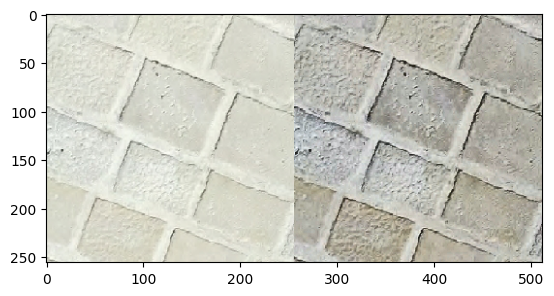

In [118]:
# Step 1: Build the profile
build_profile(reference_folder, "stanislas_profile.npz")

# Step 2: Apply to a new raw image
# img_fp = f"{target_folder}/{choice(os.listdir(target_folder))}"
src_img = cv2.imread(img_fp)
out = apply_profile(src_img, "stanislas_profile.npz", texture=0.2)

plt.imshow(np.hstack([src_img[:,:,::-1], out[:,:,::-1]]))


In [ ]:
def yolo_to_vgg(yolo_res, offset = 128, imgsz=512):
    

In [119]:
os.makedirs('new_test_images2', exist_ok=True)

In [120]:
for fn in os.listdir(target_folder):
    img = cv2.imread(f"{target_folder}/{fn}")
    n_img = apply_profile(img, "stanislas_profile.npz", texture=.2)
    cv2.imwrite(f"new_test_images2/{fn}", n_img)
    

(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)


In [107]:
def apply_texture(img, texture=0.3):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float32)
    
    # Texture enhancement (local contrast)
    L = lab[:,:,0].astype(np.uint8)
    blurred = cv2.GaussianBlur(L, (0,0), 3)
    L_tex = cv2.addWeighted(L, 1 + texture, blurred, -texture, 0)
    lab[:,:,0] = np.clip(L_tex, 0, 255)
    
    out = cv2.cvtColor(lab.astype(np.uint8), cv2.COLOR_LAB2BGR)
    return out

(256,)


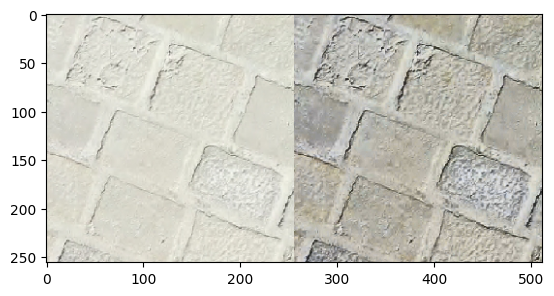

In [108]:
# img = cv2.imread("source.jpg")

# 1. Color transfer
out = apply_profile(src_img, "stanislas_profile.npz")

# 2. Exposure + Texture correction
out = apply_texture(out, texture=.1)

plt.imshow(np.hstack([src_img[:,:,::-1], out[:,:,::-1]]))
